In [26]:
# imports (no complex models)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [27]:
# preprocessing catalogue v1.0

def drop_less_or_zeros(df, columns):
    for col in columns:
        df = df[df[col] >= 0]
    return df

def drop_nans(df, columns):
    return df.dropna(subset=columns)

def fill_nans(df, columns, value):
    for col in columns:
        df[col] = df[col].fillna(value)
    return df

def remove_particles(df, column, symbols):
    df[column] = df[column].astype(str)
    for s in symbols:
        df[column] = df[column].str.replace(s, '', regex=False)
    
    return df

def build_from_columns(df, columns):
    df = df[columns].copy()
    return(df)

def one_hot_encode(df, columns):
    df = pd.get_dummies(df, columns=columns, drop_first=True)
    return df

from sklearn.preprocessing import LabelEncoder

def label_encode_columns(df, column):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    return df

def target_encode_columns(df, columns, target):
    for i in columns:
        means = df.groupby(i)[target].mean()
        df[i] = df[i].map(means)
    return df


def convert_types(df, columns, dtype):
    for col in columns:
        df[col] = df[col].astype(dtype)
    return df

def remove_outliers_iqr(df, columns, min_border, max_border, k=1.5):
    for col in columns:
        q1 = df[col].quantile(min_border)
        q3 = df[col].quantile(max_border)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

def remove_outliers_median(df, columns, n_min, n_max):
    for col in columns:
        median = df[col].median()
        lower = median - n_min * median
        upper = median + n_max * median
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

def scale_columns_train(df, columns, scaler):
    scaled = pd.DataFrame(
        scaler.fit_transform(df[columns]),
        columns=columns,
        index=df.index
    )
    df[columns] = scaled
    return df, scaler

def scale_columns_test(df, columns, scaler):
    scaled = pd.DataFrame(
        scaler.transform(df[columns]),
        columns=columns,
        index=df.index
    )
    df[columns] = scaled
    return df

def split_train_test(df, target_col, test_size, random_state=37):
    drop_cols = [target_col]
    if 'price' in df.columns:
        drop_cols.append('price')
    X = df.drop(columns=drop_cols)
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test


def split_train_val_test(df, target_col, val_size, test_size, random_state=42):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(val_size + test_size), random_state=random_state
    )
    relative_val_size = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=1 - relative_val_size, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

def remove_outliers_median_split(X, y, columns, quantile, multiplier):
    mask = pd.Series(True, index=X.index)
    
    for col in columns:
        if col in y.name:  # если столбец - это таргет
            median = y.median()
            mad = (y - median).abs().median()
            lower = median - multiplier * mad
            upper = median + multiplier * mad
            mask &= (y >= lower) & (y <= upper)
    
    return X[mask], y[mask]


In [28]:
# preprocessing v2.0
import numpy as np
import pandas as pd
from category_encoders import TargetEncoder

df = pd.read_csv('usedCarsFinal.csv')

using_columns = [
    'transmission', 'assembly', 'engine_type', 'engine_capacity',
    'registered_in', 'name', 'body_type', 'model_year', 'mileage', 'price'
]
df = build_from_columns(df, using_columns)
df = drop_nans(df, ['price', 'body_type'])

df['log_price'] = np.log1p(df['price'])

df = remove_particles(df, 'mileage', ['km', ','])
df = remove_particles(df, 'engine_capacity', ['cc', 'kWh'])
df = convert_types(df, ['engine_capacity', 'mileage'], float)
df['name'] = df['name'].str.split(' ').str[0]

df = pd.get_dummies(df, columns=['transmission', 'assembly'], drop_first=True)

X_train, X_test, y_train_log, y_test_log = split_train_test(df, 'log_price', 0.1)

# Optional: remove outliers only from training set
# X_train, y_train_log = remove_outliers_median_split(X_train, y_train_log, ['log_price'], 0.99, 6)

encoder = TargetEncoder(cols=['registered_in', 'model_year', 'body_type', 'name', 'engine_type'])
X_train = encoder.fit_transform(X_train, y_train_log)
X_test = encoder.transform(X_test)

X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 60071 entries, 50947 to 39368
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_type          60071 non-null  float64
 1   engine_capacity      60071 non-null  float64
 2   registered_in        60071 non-null  float64
 3   name                 60071 non-null  float64
 4   body_type            60071 non-null  float64
 5   model_year           60071 non-null  float64
 6   mileage              60071 non-null  float64
 7   transmission_Manual  60071 non-null  bool   
 8   assembly_Local       60071 non-null  bool   
dtypes: bool(2), float64(7)
memory usage: 3.8 MB


In [29]:
# model v2.0 (GB)
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=350, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train_log)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,350
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [30]:
# testing v2.0

# Inverse log transformation
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

# Metrics on original scale
r2 = r2_score(y_test_original, y_pred)
print(f"R² on test set: {r2:.4f}")

# Prediction range check
print("\nPredicted prices:")
print(f"  Min: {y_pred.min():,.0f}")
print(f"  Max: {y_pred.max():,.0f}")
print(f"  Median: {np.median(y_pred):,.0f}")

print("\nActual prices (test):")
print(f"  Min: {y_test_original.min():,.0f}")
print(f"  Max: {y_test_original.max():,.0f}")
print(f"  Median: {np.median(y_test_original):,.0f}")

R² on test set: 0.9103

Predicted prices:
  Min: 187,693
  Max: 92,923,326
  Median: 1,970,976

Actual prices (test):
  Min: 115,000
  Max: 65,000,000
  Median: 1,985,000


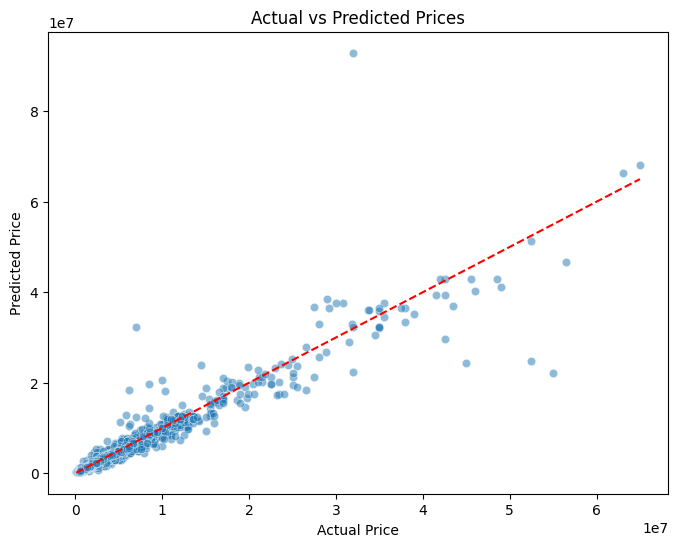

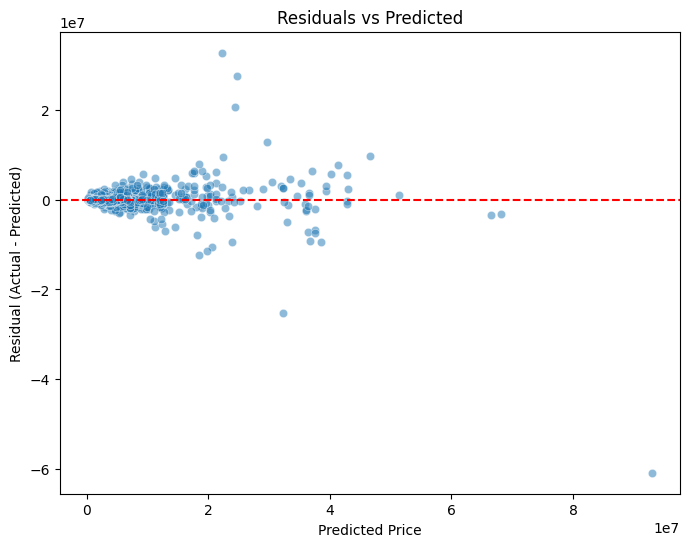

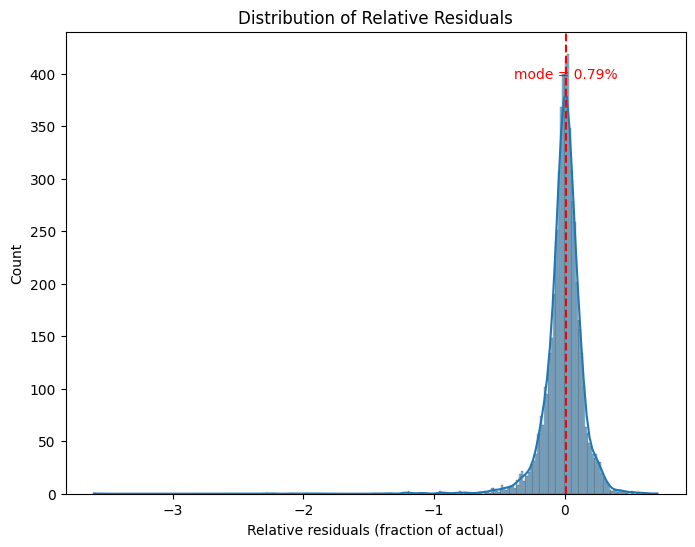

               feature  importance
7  transmission_Manual    0.380459
5           model_year    0.244789
1      engine_capacity    0.169660
4            body_type    0.090989
3                 name    0.089077
2        registered_in    0.010499
6              mileage    0.006342
8       assembly_Local    0.005401
0          engine_type    0.002783
Median price: 2,000,000


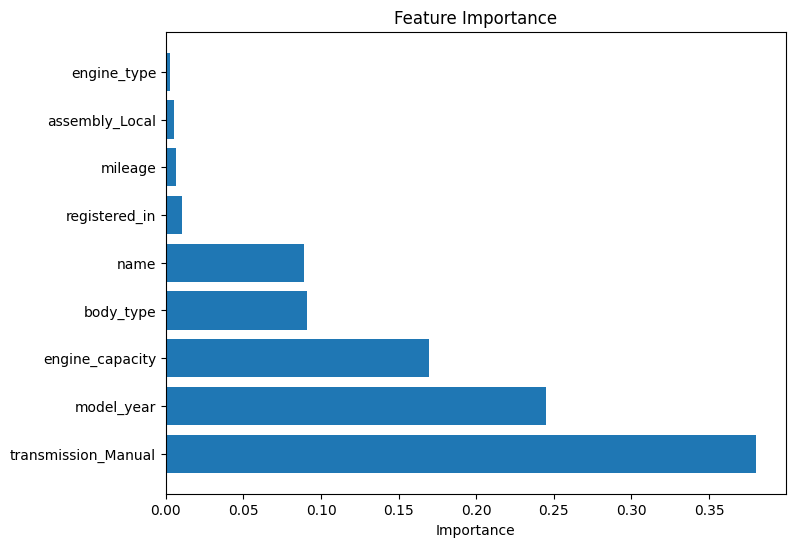

In [31]:
#visualization

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_original, y=y_pred, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()


plt.figure(figsize=(8,6))
residuals = y_test_original - y_pred
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.show()

relative_residuals = (y_test_original - y_pred) / y_test_original

relative_residuals = (y_test_original - y_pred) / y_test_original

plt.figure(figsize=(8,6))
sns.histplot(relative_residuals, kde=True)
plt.xlabel("Relative residuals (fraction of actual)")
plt.title("Distribution of Relative Residuals")

from scipy.stats import gaussian_kde
kde = gaussian_kde(relative_residuals)
xs = np.linspace(relative_residuals.min(), relative_residuals.max(), 500)
mode_x = xs[np.argmax(kde(xs))]

plt.axvline(mode_x, color='red', linestyle='--', linewidth=1.5)
plt.text(mode_x, plt.ylim()[1]*0.9, f"mode = {mode_x:.2%}", color='red', ha='center')

plt.show()

importances = model.feature_importances_
feature_names = X_train.columns

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# showing top-20
print(feat_imp.head(20))
median_price = df['price'].median()
print(f"Median price: {median_price:,.0f}")

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), np.array(X_train.columns)[indices])
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()